In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 22.9 MB/s 
     |████████████████████████████████| 120 kB 46.2 MB/s 


In [ ]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.21.40.74:8470
Number of replicas: 8


In [ ]:
MODEL_NAME = 'xlm-roberta-base'
MAX_LEN = 64
# ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 10

# if not os.path.exists(ARTIFACTS_PATH):
#     os.makedirs(ARTIFACTS_PATH)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/University/Projects/NLP/Dataset/NewsCategory6ClassImbalanced.csv')
df.head()

,headline,category,newspaper name
0,"হঠাৎ করে কেঁদে ফেললেন ঐশ্বরিয়া রাই, কেন!",Amusement,Jugantor
1,এত দামি জুতা পরেন প্রিয়াঙ্কা!,Amusement,Jugantor
2,মৃত্যুর আগে শ্রীদেবীর শেষ ভিডিও,Amusement,Jugantor
3,কৌতুক অভিনেতা কপিল শর্মার ঘরে নতুন অতিথি,Amusement,Jugantor
4,বিয়ের পর কোহলির জন্য যে ত্যাগ করলেন আনুশকা,Amusement,Jugantor


In [ ]:
import re
def cleaning_data(row):
      headlines = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return headlines
df['headline'] = df['headline'].apply(cleaning_data)

df['length'] = df['headline'].apply(lambda x:len(x.split()))

dataset = df.loc[df.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Headlines".format(len(df)-len(dataset)),
      "\nTotal Headlines:",len(dataset))
df.head()

After Cleaning: 
Removed 4098 Small Headlines 
Total Headlines: 132713


,headline,category,newspaper name,length
0,হঠাৎ করে কেঁদে ফেললেন ঐশ্বরিয়া রাই কেন,Amusement,Jugantor,7
1,এত দামি জুতা পরেন প্রিয়াঙ্কা,Amusement,Jugantor,5
2,মৃত্যুর আগে শ্রীদেবীর শেষ ভিডিও,Amusement,Jugantor,5
3,কৌতুক অভিনেতা কপিল শর্মার ঘরে নতুন অতিথি,Amusement,Jugantor,7
4,বিয়ের পর কোহলির জন্য যে ত্যাগ করলেন আনুশকা,Amusement,Jugantor,8


# Encode

In [ ]:
df['category'] = df['category'].map({'Amusement':0,'IT':1,'International':2,'national':3,'politics':4, 'sports':5})
df.head()

,headline,category,newspaper name,length
0,হঠাৎ করে কেঁদে ফেললেন ঐশ্বরিয়া রাই কেন,0,Jugantor,7
1,এত দামি জুতা পরেন প্রিয়াঙ্কা,0,Jugantor,5
2,মৃত্যুর আগে শ্রীদেবীর শেষ ভিডিও,0,Jugantor,5
3,কৌতুক অভিনেতা কপিল শর্মার ঘরে নতুন অতিথি,0,Jugantor,7
4,বিয়ের পর কোহলির জন্য যে ত্যাগ করলেন আনুশকা,0,Jugantor,8


In [ ]:
X_data = df[['headline']].to_numpy().reshape(-1)
y_data = df[['category']].to_numpy().reshape(-1)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['category'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

Texts in dataset: 136811
Number of categories: 6


# Tokenize

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Split into train, test and validation datasets
X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=777) # random_state to reproduce results
X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8, test_size = 0.2,random_state =777)

In [ ]:
# Import tokenizer from HuggingFace
from transformers import AutoTokenizer, AutoModelForMaskedLM
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)
X_valid = roberta_encode(X_valid, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')
y_valid = np.asarray(y_valid, dtype='int32')

## Create RoBERTa model

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  278043648  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_valid, y_valid))

Training...
Epoch 1/10


1540/1540 [==============================] - 480s 254ms/step - loss: 0.6232 - accuracy: 0.7650 - val_loss: 0.4546 - val_accuracy: 0.8289
Epoch 2/10
1540/1540 [==============================] - 327s 212ms/step - loss: 0.4502 - accuracy: 0.8308 - val_loss: 0.4117 - val_accuracy: 0.8457
Epoch 3/10
1540/1540 [==============================] - 307s 199ms/step - loss: 0.3854 - accuracy: 0.8547 - val_loss: 0.4175 - val_accuracy: 0.8485
Epoch 4/10
1540/1540 [==============================] - 338s 219ms/step - loss: 0.3399 - accuracy: 0.8717 - val_loss: 0.3859 - val_accuracy: 0.8586
Epoch 5/10
1540/1540 [==============================] - 323s 210ms/step - loss: 0.2940 - accuracy: 0.8881 - val_loss: 0.3852 - val_accuracy: 0.8627
Epoch 6/10
1540/1540 [==============================] - 321s 209ms/step - loss: 0.2577 - accuracy: 0.9012 - val_loss: 0.3865 - val_accuracy: 0.8666
Epoch 7/10
1540/1540 [==============================] - 318s 207ms/step - loss: 0.2250 - accuracy: 0.9143 - val_loss: 0.406

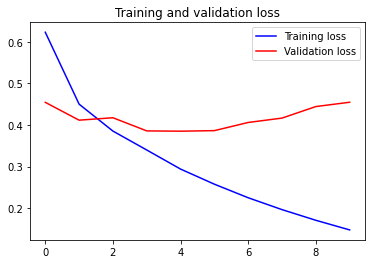

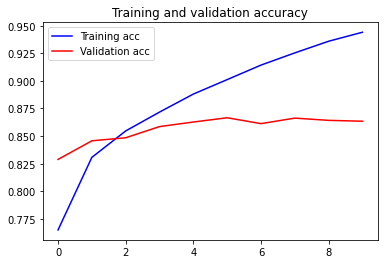

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, accuracy, 'blue', label='Training acc')
plt.plot(epochs, val_accuracy, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.show()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [ ]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in model.predict(X_test)]

In [ ]:
from sklearn.metrics import classification_report
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Amusement','1':'IT','2':'International','3':'National','4':'Politics','5':'Sports'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
Amusement,84.62,91.92,88.12,1646.000000
IT,73.33,68.98,71.09,303.000000
International,92.22,90.91,91.56,4821.000000
National,75.85,74.83,75.34,2539.000000
Politics,68.24,71.03,69.61,1077.000000
Sports,94.89,92.99,93.93,3296.000000
accuracy,86.50,86.50,86.50,0.865005
macro avg,81.53,81.78,81.61,13682.000000
weighted avg,86.60,86.50,86.53,13682.000000


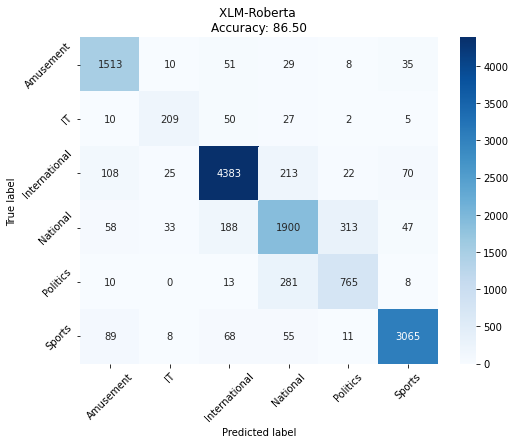

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     
                     index = ['Amusement' ,'IT' ,'International', 'National', 'Politics', 'Sports'], 
                     columns = ['Amusement' ,'IT' ,'International', 'National', 'Politics', 'Sports'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Blues", fmt='g')
plt.title('XLM-Roberta \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()